In [1]:
import gym
import gym.spaces
from gym.utils import seeding
from gym.envs.registration import EnvSpec
import enum
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import random
from scipy.stats import boxcox
from fracdiff.sklearn import FracdiffStat
#frac = FracdiffStat()
from collections import deque
import tensorflow_probability as tfp
import time
import tensorflow.keras.losses as kls
from adabelief_tf import AdaBeliefOptimizer

In [3]:
def WMA(data, period=20):
    wma = []
    divisor = (period*(period+1))/2
    for i in range(len(data)):
        div = divisor
        num = 0
        for a in range(period):
            if (i-a) >= 0:
                num += data[i-a] * (period - a)
            elif (i-a) < 0:
                div -= period - a
        num = num/div
        wma.append(num)
    return np.array(wma)

In [4]:
def hull_ma(data, period=20):
    half = round(period/2)
    wma1 = WMA(data, half)
    wma2 = WMA(data, period)
    raw_wma = (2*wma1) - wma2
    sqrt = round(period ** 0.5)
    hma = WMA(raw_wma, sqrt)
    return hma

In [5]:
def sharpe(ls):
    return np.mean(ls)/np.std(ls)

In [6]:
DEFAULT_BARS_COUNT = 63
DEFAULT_COMMISSION_PERC = 0.0025

In [7]:
class CGA_Env(Env):
    metadata = {'render.modes': ['human']}
    spec = EnvSpec('StocksEnv-v0') #not quite sure what this does, but 
    #i might change the name
    
    def __init__(self, prices, bars_count=DEFAULT_BARS_COUNT,
                commission_perc=DEFAULT_COMMISSION_PERC, state_1d=True,
                random_ofs_on_reset=True, reward_on_close=True, noise_on=True):
        
        #assert isinstance(prices, dict)
        self._prices = prices
        
        bars_count = int(bars_count)
        self.bars_count = bars_count
        self.noise_on = noise_on
        
        if state_1d:
            self._state = State1D(prices,
                bars_count=DEFAULT_BARS_COUNT, commission_perc=DEFAULT_COMMISSION_PERC,
                reward_on_close=reward_on_close, noise_on=self.noise_on)
        else:
            self._state = State(prices,
                bars_count=DEFAULT_BARS_COUNT, commission_perc=DEFAULT_COMMISSION_PERC,
                reward_on_close=reward_on_close)
            
        #Observation array    
        self.observation_space = Box(low=-np.inf, high=np.inf,
                                    shape=self._state.shape, 
                                     dtype=np.float32)
        
        self.random_ofs_on_reset = random_ofs_on_reset
        self.seed()
        
    def step(self, action):
        reward, close_reward, done, rl_action = self._state.step(action)
        obs = self._state.encode()
        info = {
            #figure out what to do for info
            'offset': self._state._offset
        }
        return obs, reward, done, info, close_reward, rl_action
        
    def reset(self):
        prices = self._prices
        bars = self._state.bars_count
        noise_on = self.noise_on
        if self.random_ofs_on_reset:
            offset = np.random.choice(
                prices.close.shape[0]-bars*5) + bars
        else:
            offset = bars
        self._state.reset(prices, offset)
        return self._state.encode()
    
    '''def render(self, mode='human', close=False):
        pass
    
    def close(self):
        pass
    
    def seed(self, seed=None):
        self.n_random, seed1 = seeding.np_random(seed)
        seed2 = seeding.hash_seed(seed1 + 1) % 2 ** 31
        return [seed1, seed2]
    
    @classmethod
    def from_dir(cls, data_dir, **kwargs):
        prices = {
            file: data.load_relative(file)
            for file in data.price_files(data_dir)
        }
        return EAM_Env(prices, **kwargs)'''

In [8]:
DATA_STORE = 'my_model_data.h5'

In [9]:
class State:
    def __init__(self, prices, bars_count, commission_perc,
                 reward_on_close=True, noise_on=True):
        assert isinstance(bars_count, int)
        assert bars_count > 0
        assert isinstance(commission_perc, float)
        assert commission_perc >= 0.0
        assert isinstance(reward_on_close, bool)
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        self.reward_on_close = reward_on_close
        self.noise_on = noise_on
        
        
    def reset(self, prices, offset):
        assert isinstance(prices, pd.DataFrame)
        assert offset >= self.bars_count-1
        self.position = False
        self.position_buyin_value = 0
        self._prices = prices
        self._offset = offset
        self.reward_trail = 0
        self.reward_cumsum = 0
        self.last_action = 0
        self.noise = 0
        self.dsr = 0
        self.a = 0
        self.b = 0
        
    @property
    def shape(self):
        # [c, h, l, o, ...] * bars + position_flag + rel_profit
        return 20 * self.bars_count
    
    def encode(self):
        #Convert current state into numpy array.
        
        res = np.ndarray(shape=self.shape, dtype=np.float32)
        shift = 0
        #start_index_value = -self.bars_count + 1 + self._offset
        for bar_idx in range(-self.bars_count+1, 1):
            ofs = self._offset + bar_idx
            res[shift] = self._prices.close[ofs] #/self._prices.close[start_index_value]
            shift += 1
            res[shift] = self._prices.high[ofs] #/self._prices.high[start_index_value]
            shift += 1
            res[shift] = self._prices.low[ofs] #/self._prices.low[start_index_value]
            shift += 1
            res[shift] = self._prices.open[ofs] #/self._prices.open[start_index_value]
            shift += 1
            res[shift] = self._prices.volume[ofs] #/self._prices.volume[start_index_value]
            shift += 1
            res[shift] = self._prices.OPM[ofs] #/self._prices.OPM[start_index_value]
            shift += 1
            res[shift] = self._prices.NPM[ofs] #/self._prices.NPM[start_index_value]
            shift += 1
            res[shift] = self._prices.ROA[ofs] #/self._prices.ROA[start_index_value]
            shift += 1
            res[shift] = self._prices.ROE[ofs] #/self._prices.ROE[start_index_value]
            shift += 1
            res[shift] = self._prices.cur_ratio[ofs] #/self._prices.cur_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.quick_ratio[ofs] #/self._prices.quick_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.cash_ratio[ofs] #/self._prices.cash_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.inv_turnover[ofs] #/self._prices.inv_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.acc_rec_turnover[ofs] #/self._prices.acc_rec_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.acc_pay_turnover[ofs] #/self._prices.acc_pay_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.debt_ratio[ofs] #/self._prices.debt_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.debt_to_equity[ofs] #/self._prices.debt_to_equity[start_index_value]
            shift += 1
            res[shift] = self._prices.PE[ofs] #/self._prices.PE[start_index_value]
            shift += 1
            res[shift] = self._prices.PB[ofs] #/self._prices.PB[start_index_value]
            shift += 1
            res[shift] = self._prices.Div_yield[ofs] #/self._prices.Div_yield[start_index_value]
            shift += 1
        res[shift] = self.position
        shift += 1
        res[shift] = self.asset_undermanagement_percent() #self.asset_undermanagement_percent()
        return res
    
    def _cur_close(self):
        #Calculate the current close price
        return self._prices.close[self._offset]
    
    '''def percent_gained(self):
        #calculate the percentage of profit the bot would stand to realize if the asset was liquidated
        if (self.position > 0) & (self.position_buyin_tot_value > 0):
            return ((self.position * self._cur_close()) / self.position_buyin_tot_value) - self.commission_perc - 1
        else:
            return 0.0'''
    
    def reward_calculate(self, reward, n=0.1):
        a = n*reward + (1-n)*self.a
        b = n*(reward**2) + (1-n)*self.b
        delta_a = reward - self.a
        delta_b = reward**2 - self.b
        
        dt = ((self.b*delta_a) - (0.5*self.a*delta_b))/(((self.b-(self.a**2))**1.5)+1e-7)
        dsr = n*dt
        if (self.a != 0) & (self.b != 0):
            self.dsr += dsr
        self.b = b
        self.a = a

        return self.dsr
        
    def step(self, action, d=0.1):
        #Perform a step in the price, adjust offset, check for the end of epoch, 
        # and handle position change
        # :param action:
        # :return: reward, done
        
        #assert isinstance(action, int)
        reward = 0.0
        close_reward=1
        
        if self._prices.signals[self._offset] == 1:
            action = action * (-1)
        
        #print(reward)
        done = False
        close = self._cur_close() + self.noise
            
        self._offset += 1
        prev_close = close
        close = self._cur_close()
        
        if self._offset >= self._prices.close.shape[0] - 1:
            done = True
            
        if action > 0:
            reward = ((close/prev_close) - 1 - (self.commission_perc * abs(action - self.last_action))) * action
            return_ = (reward) + 1 
        elif action < 0:
            reward = ((1 - (close/prev_close)) - (self.commission_perc * abs(action - self.last_action))) * abs(action)
            return_ = (reward) + 1 
        else:
            reward = -1 * (self.commission_perc * abs(action - self.last_action))
            return_ = 1 - (self.commission_perc * abs(action - self.last_action))
            
        #reward = self.reward_calculate(reward) * 100
        #self.reward_trail = d*reward + (1-d)*self.reward_trail
        #real_reward = self.reward_trail * 100
        self.reward_cumsum += np.log(return_) * 100
        self.last_action = action
        
        return self.reward_cumsum, return_, done, action

In [10]:
class State1D(State):
    #state with shape suitable for 1D convolution
    
    @property
    def shape(self):
        return (22, self.bars_count)
    
    def encode(self):
        res = np.zeros(shape=self.shape, dtype=np.float32)
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        
        std = np.std(self._prices.close[start:stop])
        shape = self._prices.close[start:stop].shape
        if self.noise_on:
            noise = np.random.normal(loc=0, scale=0.1, size=shape)*(std*0.1)
            self.noise=noise[-1]
        elif not self.noise_on:
            noise = 0
            self.noise = 0
        
        res[0] = np.log(self._prices.close[start:stop])
        #res[1] = np.log(self._prices.HMA[start:stop])
        res[1] = np.log(self._prices.high[start:stop])
        res[2] = np.log(self._prices.low[start:stop])
        res[3] = np.log(self._prices.volume[start:stop])
        res[4] = self._prices.OPM[start:stop]
        res[5] = self._prices.NPM[start:stop]
        res[6] = self._prices.ROA[start:stop]
        res[7] = self._prices.ROE[start:stop]
        res[8] = self._prices.cur_ratio[start:stop]
        res[9] = self._prices.quick_ratio[start:stop]
        res[10] = self._prices.cash_ratio[start:stop]
        res[11] = self._prices.inv_turnover[start:stop]
        res[12] = self._prices.acc_rec_turnover[start:stop]
        res[13] = self._prices.acc_pay_turnover[start:stop]
        res[14] = self._prices.debt_ratio[start:stop]
        res[15] = self._prices.debt_to_equity[start:stop]
        res[16] = self._prices.PE[start:stop]
        res[17] = self._prices.PB[start:stop]
        res[18] = self._prices.Div_yield[start:stop]
        res[19] = self._prices.signals[start:stop]
        res[20] = self.last_action
        
        for i in range(3):
            res[i] = res[i] + noise
        
        for i in reversed(range(3)):
            res[i] = res[i] / res[0][-1]
        res[4] = res[4] / np.log(self._prices.volume[stop-1])
        
        res[21] = hull_ma(res[0], 10)
        
        return res

In [11]:
with pd.HDFStore('sga_signals.h5') as store:
    msft_signals = store['sga/train_valid_test/msft']
    dis_signals = store['sga/train_valid_test/dis']
    jnj_signals = store['sga/train_valid_test/jnj']

In [12]:
with pd.HDFStore('my_model_data.h5') as store:
    msft_train = store['dow/stock_fund/sga/training/msft']
    msft_valid = store['dow/stock_fund/sga/valid/msft']
    dis_train = store['dow/stock_fund/sga/training/dis']
    dis_valid = store['dow/stock_fund/sga/valid/dis']
    jnj_train = store['dow/stock_fund/sga/training/jnj']
    jnj_valid = store['dow/stock_fund/sga/valid/jnj']
    msft_test = store['dow/stock_fund/EAM/testing_section/w_hma/msft']
    dis_test = store['dow/stock_fund/EAM/testing_section/w_hma/dis']
    jnj_test = store['dow/stock_fund/EAM/testing_section/w_hma/jnj']

In [13]:
msft_test = msft_test[2012:]
dis_test = dis_test[2012:]
jnj_test = jnj_test[2012:]

In [14]:
msft_test.reset_index(inplace=True, drop=True)
dis_test.reset_index(inplace=True, drop=True)
jnj_test.reset_index(inplace=True, drop=True)

In [15]:
msft_two = msft_train.append(msft_valid, ignore_index=True)
dis_two = dis_train.append(dis_valid, ignore_index=True)
jnj_two = jnj_train.append(jnj_valid, ignore_index=True)
msft = msft_two.append(msft_test, ignore_index=True)
dis = dis_two.append(dis_test, ignore_index=True)
jnj = jnj_two.append(jnj_test, ignore_index=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_30300\3134887650.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msft_two = msft_train.append(msft_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_30300\3134887650.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis_two = dis_train.append(dis_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_30300\3134887650.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jnj_two = jnj_train.append(jnj_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_30300\3134887650.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msft = msft_two.ap

In [16]:
dis_signals.shape

(5221,)

In [17]:
msft.shape

(5284, 23)

In [18]:
msft_signals.reset_index(inplace=True, drop=True)
dis_signals.reset_index(inplace=True, drop=True)
jnj_signals.reset_index(inplace=True, drop=True)

In [19]:
msft = msft[63:]
dis = dis[63:]
jnj = jnj[63:]
msft.reset_index(inplace=True, drop=True)
dis.reset_index(inplace=True, drop=True)
jnj.reset_index(inplace=True, drop=True)

In [20]:
msft.shape

(5221, 23)

In [21]:
msft['signals'] = msft_signals
dis['signals'] = dis_signals
jnj['signals'] = jnj_signals

In [22]:
msft_train = msft[:4214]
dis_train = dis[:4214]
jnj_train = jnj[:4214]
msft_valid = msft[4214:4716]
dis_valid = dis[4214:4716]
jnj_valid = jnj[4214:4716]
msft_test = msft[4716:]
dis_test = dis[4716:]
jnj_test = jnj[4716:]

In [23]:
msft_valid.reset_index(inplace=True, drop=True)
dis_valid.reset_index(inplace=True, drop=True)
jnj_valid.reset_index(inplace=True, drop=True)
msft_test.reset_index(inplace=True, drop=True)
dis_test.reset_index(inplace=True, drop=True)
jnj_test.reset_index(inplace=True, drop=True)

In [45]:
'''with pd.HDFStore(DATA_STORE) as store:
    store.put('dow/stock_fund/cga/training/w_signals/msft', msft_train)
    store.put('dow/stock_fund/cga/training/w_signals/dis', dis_train)
    store.put('dow/stock_fund/cga/training/w_signals/jnj', jnj_train)
    
    store.put('dow/stock_fund/cga/valid/w_signals/msft', msft_valid)
    store.put('dow/stock_fund/cga/valid/w_signals/dis', dis_valid)
    store.put('dow/stock_fund/cga/valid/w_signals/jnj', jnj_valid)
    
    store.put('dow/stock_fund/cga/test/w_signals/msft', msft_test)
    store.put('dow/stock_fund/cga/test/w_signals/dis', dis_test)
    store.put('dow/stock_fund/cga/test/w_signals/jnj', jnj_test)
    
    store.put('dow/stock_fund/cga/all_data/w_signals/msft', msft)
    store.put('dow/stock_fund/cga/all_data/w_signals/dis', dis)
    store.put('dow/stock_fund/cga/all_data/w_signals/jnj', jnj)'''

In [24]:
msft_env = CGA_Env(msft_train, reward_on_close=True)
dis_env = CGA_Env(dis_train, reward_on_close=True)
jnj_env = CGA_Env(jnj_train, reward_on_close=True)

msft_valid_env = CGA_Env(msft_valid, random_ofs_on_reset=False, noise_on=False)
dis_valid_env = CGA_Env(dis_valid, random_ofs_on_reset=False, noise_on=False)
jnj_valid_env = CGA_Env(jnj_valid, random_ofs_on_reset=False, noise_on=False)

msft_test_env = CGA_Env(msft_test, random_ofs_on_reset=False, noise_on=False)
dis_test_env = CGA_Env(dis_test, random_ofs_on_reset=False, noise_on=False)
jnj_test_env = CGA_Env(jnj_test, random_ofs_on_reset=False, noise_on=False)

In [25]:
input_shape = [22, 63]

In [26]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, 3, strides=strides,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv1D(filters, 3, strides=1,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, 1, strides=strides,
                                   padding='same', use_bias=False),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [27]:
class NoisyDense(keras.layers.Layer):
    def __init__(self, units, scale, activation='elu', kernel_initializer='he_uniform', noise_on=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.scale = scale
        self.activation = keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer
        self.noise_on = noise_on

    def build(self, input_shape):
        self.mu_w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer=self.kernel_initializer,
                               trainable=True)
        self.mu_b = self.add_weight(shape=(self.units,),
                               initializer=self.kernel_initializer,
                               trainable=True)
        self.sigma_w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer=self.kernel_initializer,
                               trainable=True)
        self.sigma_b = self.add_weight(shape=(self.units,),
                               initializer=self.kernel_initializer,
                               trainable=True)

    def call(self, inputs):
        if self.noise_on:
            e_w = np.random.normal(loc=0, scale=self.scale, size=self.units)
            noise_w = tf.multiply(self.sigma_w, e_w)
            w = noise_w + self.mu_w

            e_b = np.random.normal(loc=0, scale=self.scale, size=(self.units,))
            noise_b = tf.multiply(self.sigma_b, e_b)
            b = noise_b + self.mu_b
        elif not self.noise_on:
            w = self.mu_w
            b = self.mu_b
        
        return self.activation(tf.matmul(inputs, w) + b)

In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [29]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
hidden1 = keras.layers.Conv1D(64, 7, strides=2, input_shape=input_shape,
                             padding='same', use_bias=False, kernel_regularizer=keras.regularizers.L2(l2=1e-8))(input_states)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = keras.layers.Activation('relu')(hidden2)
hidden4 = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(hidden3)
resunit1 = ResidualUnit(64, strides=1)(hidden4)
resunit2 = ResidualUnit(64, strides=1)(resunit1)
resunit3 = ResidualUnit(64, strides=1)(resunit2)
resunit4 = ResidualUnit(128, strides=2)(resunit3)
resunit5 = ResidualUnit(128, strides=1)(resunit4)
resunit6 = ResidualUnit(128, strides=1)(resunit5)
resunit7 = ResidualUnit(128, strides=1)(resunit6)
resunit8 = ResidualUnit(256, strides=2)(resunit7)
resunit9 = ResidualUnit(256, strides=1)(resunit8)
resunit10 = ResidualUnit(256, strides=1)(resunit9)
resunit11 = ResidualUnit(256, strides=1)(resunit10)
resunit12 = ResidualUnit(256, strides=1)(resunit11)
resunit13 = ResidualUnit(256, strides=1)(resunit12)
resunit14 = ResidualUnit(512, strides=2)(resunit13)
resunit15 = ResidualUnit(512, strides=1)(resunit14)
resunit16 = ResidualUnit(512, strides=1)(resunit15)
hidden5 = keras.layers.GlobalAvgPool1D()(resunit16)
flat = keras.layers.Flatten()(hidden5)
dense_act = NoisyDense(256, scale=0.1)(flat)
#dense_value = NoisyDense(256, scale=0.1)(hidden6)
#dense_value = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
#dense_adv = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
action = keras.layers.Dense(1, activation = 'sigmoid')(dense_act)
#state_value = keras.layers.Dense(1, activation = 'relu')(dense_value)
actor = keras.models.Model(inputs=[input_states], outputs=[action])

In [30]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
hidden1 = keras.layers.Conv1D(64, 7, strides=2, input_shape=input_shape,
                             padding='same', use_bias=False, kernel_regularizer=keras.regularizers.L2(l2=1e-8))(input_states)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = keras.layers.Activation('relu')(hidden2)
hidden4 = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(hidden3)
resunit1 = ResidualUnit(64, strides=1)(hidden4)
resunit2 = ResidualUnit(64, strides=1)(resunit1)
resunit3 = ResidualUnit(64, strides=1)(resunit2)
resunit4 = ResidualUnit(128, strides=2)(resunit3)
resunit5 = ResidualUnit(128, strides=1)(resunit4)
resunit6 = ResidualUnit(128, strides=1)(resunit5)
resunit7 = ResidualUnit(128, strides=1)(resunit6)
resunit8 = ResidualUnit(256, strides=2)(resunit7)
resunit9 = ResidualUnit(256, strides=1)(resunit8)
resunit10 = ResidualUnit(256, strides=1)(resunit9)
resunit11 = ResidualUnit(256, strides=1)(resunit10)
resunit12 = ResidualUnit(256, strides=1)(resunit11)
resunit13 = ResidualUnit(256, strides=1)(resunit12)
resunit14 = ResidualUnit(512, strides=2)(resunit13)
resunit15 = ResidualUnit(512, strides=1)(resunit14)
resunit16 = ResidualUnit(512, strides=1)(resunit15)
hidden5 = keras.layers.GlobalAvgPool1D()(resunit16)
flat = keras.layers.Flatten()(hidden5)
dense_value = NoisyDense(256, scale=0.1)(flat)
state_value = keras.layers.Dense(1, activation = 'relu')(dense_value)
critic = keras.models.Model(inputs=[input_states], outputs=[state_value])

In [31]:
def save_model(path, name, model):
    now_weights = model.get_weights()
    now_weights_series = pd.Series(now_weights)
    with pd.HDFStore(path) as store:
        store.put(name, now_weights_series)

In [32]:
def load_model(path, name, model):
    with pd.HDFStore(path) as store:
        weights = store[name]
    list_weights = weights.to_list()
    model.set_weights(list_weights)

In [59]:
actor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 22, 63)]          0         
                                                                 
 conv1d_72 (Conv1D)          (None, 11, 64)            28224     
                                                                 
 batch_normalization_72 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 11, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 residual_unit_32 (ResidualU  (None, 6, 64)            2508

In [33]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
hidden1 = keras.layers.Conv1D(64, 7, strides=2, input_shape=[20,63],
                             padding='same', use_bias=False)(input_states)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = keras.layers.Activation('relu')(hidden2)
hidden4 = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(hidden3)
resunit1 = ResidualUnit(64, strides=1)(hidden4)
resunit2 = ResidualUnit(64, strides=1)(resunit1)
resunit3 = ResidualUnit(64, strides=1)(resunit2)
resunit4 = ResidualUnit(128, strides=2)(resunit3)
resunit5 = ResidualUnit(128, strides=1)(resunit4)
resunit6 = ResidualUnit(128, strides=1)(resunit5)
resunit7 = ResidualUnit(128, strides=1)(resunit6)
resunit8 = ResidualUnit(256, strides=2)(resunit7)
resunit9 = ResidualUnit(256, strides=1)(resunit8)
resunit10 = ResidualUnit(256, strides=1)(resunit9)
resunit11 = ResidualUnit(256, strides=1)(resunit10)
resunit12 = ResidualUnit(256, strides=1)(resunit11)
resunit13 = ResidualUnit(256, strides=1)(resunit12)
resunit14 = ResidualUnit(512, strides=2)(resunit13)
resunit15 = ResidualUnit(512, strides=1)(resunit14)
resunit16 = ResidualUnit(512, strides=1)(resunit15)
hidden5 = keras.layers.GlobalAvgPool1D()(resunit16)
flat = keras.layers.Flatten()(hidden5)
dense_act = NoisyDense(256, scale=0.1, noise_on=False)(flat)
#dense_value = NoisyDense(256, scale=0.1, noise_on=False)(hidden6)
#dense_value = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
#dense_adv = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
action = keras.layers.Dense(1, activation = 'hard_sigmoid')(dense_act)
#state_value = keras.layers.Dense(1, activation = 'relu')(dense_value)
valid_model = keras.models.Model(inputs=[input_states], outputs=[action])
valid_model.set_weights(actor.get_weights())

In [34]:
load_model('cga_weights.h5', 'cga/msft/noisydense/noisydata/0to1/151episodes', actor)

In [35]:
replay_buffer = []
'''with pd.HDFStore('sga_buffer.h5') as store:
    replay_series = store['sga/msft/noisydata/log/354episodes']
replay_buffer = replay_series.to_list()'''

"with pd.HDFStore('sga_buffer.h5') as store:\n    replay_series = store['sga/msft/noisydata/log/354episodes']\nreplay_buffer = replay_series.to_list()"

In [36]:
batch_size = 48
gamma = 0.99
clip_param = 0.2

In [37]:
start = 5
iterations = 128 #used to be 64
update_steps = 3
episodes = 180
episode_chunks = 5
valid_run_steps = 1

In [38]:
def actor_loss(probs, adv, old_probs):
    probability = probs
    entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability+2,tf.math.log(probability+2))))
    #print(probability)
    #print(entropy)
    sur1 = []
    sur2 = []
        
    for pb, t, op in zip(probability, adv, old_probs):
        t = tf.constant(t)
        op = tf.constant(op)
        #print(t)
        ratio = tf.reduce_mean(tf.math.exp(tf.math.log(pb + 2) - tf.math.log(op + 2)))
        #print(ratio)
        s1 = tf.math.multiply(ratio, t)
        #print(s1)
        s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0 - clip_param, 1.0+clip_param), t)
        #print(s2)
        sur1.append(s1)
        sur2.append(s2)
            
    sr1 = tf.stack(sur1)
    sr2 = tf.stack(sur2)
        
    #is the 0.001 a hyperparameter?
    loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) + 0.001*entropy)
    return loss

In [39]:
def learn(batch_size):
    
    #discount_rewards = tf.reshape(discount_rewards, (len(discount_rewards),))
    #adv = tf.reshape(adv, (len(adv),))
    #old_p = old_probs
    #old_p = tf.reshape(old_p, (len(old_p),4))
    
    batch_states, batch_adv, batch_old_p, batch_discount_rewards = batch_maker(batch_size)
    
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        p = actor(batch_states) #what the frcikle frack
        #print(p)
        v = critic(batch_states)
        v = tf.reshape(v, (len(v),))
    
        td = tf.math.subtract(batch_discount_rewards, v)
        closs = 0.5 * kls.mean_squared_error(batch_discount_rewards, v)
        #print(closs)
        #closs = closs.numpy()
        aloss = actor_loss(p, batch_adv, batch_old_p)
        #print(aloss)
            
    grads1 = tape1.gradient(aloss, actor.trainable_variables)
    grads2 = tape2.gradient(closs, critic.trainable_variables)
    a_optimizer.apply_gradients(zip(grads1, actor.trainable_variables))
    c_optimizer.apply_gradients(zip(grads2, critic.trainable_variables))
    return aloss, closs

In [40]:
def batch_maker(batch_size=50):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, adv, probs, rewards = [np.array([experience[field_index] for experience in batch])
                                  for field_index in range(4)]
    
    #batch_states = [states[index] for index in indices]
    #batch_adv = [adv[index] for index in indices]
    #batch_probs = [probs[index] for index in indices]
    #batch_reward_lst = [reward_list[index] for index in indices]
    
    return states, adv, probs, rewards

In [41]:
def loss_calculator(states, adv, old_p, discount_rewards):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        p = actor(np.array(states)) #what the frcikle frack
        #print(p)
        v = critic(np.array(states))
        v = tf.reshape(v, (len(v),))
        #print(v)
        td = tf.math.subtract(discount_rewards, v)
        closs = 0.5 * kls.mean_squared_error(discount_rewards, v)
        aloss = actor_loss(p, adv, old_p)
    
    return aloss, closs

In [42]:
def valid_run(env):
    done = False
    state = env.reset()
    cumprod_return = 1
    rewards = []
    #states = []
    probs = []
    actions = []
    #dones = []
    day_returns = []
    #values = []
    num_steps = 0
    #alosses = 0
    #closses = 0
    
    while not done:
        action = actor(np.array([state])).numpy()[0][0]
        #value = critic(np.array([state])).numpy()
        next_state, reward, done, info, day_return, rl_action = env.step(action)
        #dones.append(1-done)
        cumprod_return *= day_return
        day_returns.append(day_return)
        rewards.append(reward)
        #states.append(state)
        probs.append(action)
        actions.append(rl_action)
        #values.append(value[0][0])
        state = next_state
        num_steps += 1
        
    #value = critic(np.array([state])).numpy()
    #values.append(value[0][0])
    #np.reshape(probs, (len(probs),))
    #probs = np.stack(probs, axis=0)
    
    arr = (cumprod_return ** (1/(num_steps/252)))
    reward_mean = np.mean(rewards) 
    
    #states, returns, adv = preprocess(states, rewards, dones, values, 0.99) #change the gamma value
    
    #aloss, closs = loss_calculator(states, adv, probs, returns)
        
    return reward_mean, arr, rewards, actions, day_returns

In [43]:
def preprocess(states, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * dones[i] * g
        returns.append(g + values[i])
        
    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    returns = np.array(returns, dtype=np.float32)
    return states, returns, adv 

In [43]:
#with pd.HDFStore('sga_progress.h5') as store:
#    reward_series = store['sga/msft/reward/training250']
#    vreward_series = store['sga/msft/valid_reward/training250']

In [44]:
#reward_list = reward_series.to_list()
#vreward_list = vreward_series.to_list()
reward_list = []
vreward_list = []
arr_list = []
varr_list = []
all_aloss = []
all_closs = []
best_arr = -np.inf
durations = []
best_weights = None

In [45]:
def one_cycle(i, max_length, start, max_):
    midway = 0.4*max_length
    almost = 0.8*max_length
    if i <= midway:
        lr = (((4.5e-7)/250)*i + 5e-8)
    elif (i > midway) & (i <= almost):
        lr = (((4.5e-7)/250)*(-i) - 5e-8 + 1e-6)
    elif (i > almost) & (i <= max_length):
        lr = ((-3.96e-10)*i) + 2.48e-7
 
    return lr

In [46]:
def exp_lr(episode, start_lr, end_lr, episodes):
    num = start_lr/end_lr
    num2 = np.log(num) / episodes
    return (start_lr * np.exp((-episode)*num2))

In [47]:
for episode in range(0, 151):
    begin = time.time()
    env = dis_env
    valid_env = dis_valid_env
    env_type = 'DIS'
        
    a_optimizer = AdaBeliefOptimizer(learning_rate=exp_lr(episode, 1e-6, 5e-8, episodes), epsilon=1e-14, rectify=False, print_change_log = False)
    c_optimizer = AdaBeliefOptimizer(learning_rate=exp_lr(episode, 5e-6, 5e-8, episodes), epsilon=1e-14, rectify=False, print_change_log = False)
    #a_optimizer = keras.optimizers.Adam(exp_lr(episode, 5e-6, 5e-8, episodes))
    #c_optimizer = keras.optimizers.Adam(exp_lr(episode, 1e-6, 1e-8, episodes))
    print('-------------------------------------------------------------')
    
    done = False
    state = env.reset()
    cumprod_return = 1
    rewards = []
    states = []
    probs = []
    dones = []
    values = []
    num_steps = 0
    alosses = 0
    closses = 0
    
    while not done:
        action = actor(np.array([state])).numpy()[0][0]
        value = critic(np.array([state])).numpy()
        next_state, reward, done, info, day_return, _ = env.step(action)
        dones.append(1-done)
        cumprod_return *= day_return
        rewards.append(reward)
        states.append(state)
        probs.append(action)
        values.append(value[0][0])
        state = next_state
        num_steps += 1
        
    value = critic(np.array([state])).numpy()
    values.append(value[0][0])
    np.reshape(probs, (len(probs),))
    probs = np.stack(probs, axis=0)
    
    arr = (cumprod_return ** (1/(num_steps/252)))
    reward_mean = np.mean(rewards) 
    
    reward_list.append(reward_mean)
    arr_list.append(arr)
    
    states, returns, adv = preprocess(states, rewards, dones, values, 0.99)
    
    for i in range(len(states)):
        datapoint = (states[i], adv[i], probs[i], returns[i])
        replay_buffer.append(datapoint)
    
    if episode > 90:
        if (len(arr_list[20:]) - np.argmax(arr_list[20:]) - 1) > 25:
            break
            
    if len(replay_buffer) > 60000:
        for i in range(4000):
            replay_buffer.pop(0)
        
    if episode >= 0:
            
        if episode % valid_run_steps == 0:
            valid_model.set_weights(actor.get_weights())
            
            vreward_mean, varr, nothin, nothing, _  = valid_run(valid_env)
            vreward_list.append(vreward_mean)
            varr_list.append(varr)
            
            if varr > best_arr:
                best_weights = valid_model.get_weights()
                best_arr = varr
        
        for i in range(iterations):
            aloss, closs = learn(48)
            all_aloss.append(aloss)
            all_closs.append(closs)
            alosses += aloss
            closses += closs
    
    stop = time.time()
    duration = stop-begin
    durations.append(duration)
    print('Training:')
    print('Episode: {}, Steps: {}, Reward_mean: {}, ARR: {}, Stock: {}'.format(episode, num_steps, round(reward_mean, 3), round(arr, 3), env_type))
    print('Learning_rate: {}, Actor Loss: {}, Critic Loss: {}'.format(round(exp_lr(episode, 1e-6, 5e-8, episodes),8), alosses, closses))
    print('\n')
    if (episode % valid_run_steps == 0) & (episode >= 0):
        print('Validation:')
        print('{} Reward_mean: {}, ARR: {}'.format(env_type, round(vreward_mean,3), round(varr, 3)))
        print('\n')
    print('Duration: {}'.format(round(duration,2)))

-------------------------------------------------------------
Training:
Episode: 0, Steps: 485, Reward_mean: -5.279, ARR: 0.958, Stock: DIS
Learning_rate: 1e-06, Actor Loss: -3.4930598735809326, Critic Loss: 2500434.5


Validation:
DIS Reward_mean: -5.921, ARR: 0.981


Duration: 193.38
-------------------------------------------------------------
Training:
Episode: 1, Steps: 2361, Reward_mean: 58.678, ARR: 1.118, Stock: DIS
Learning_rate: 9.8e-07, Actor Loss: -2.170133590698242, Critic Loss: 80158496.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 361.3
-------------------------------------------------------------
Training:
Episode: 2, Steps: 2795, Reward_mean: 18.415, ARR: 1.051, Stock: DIS
Learning_rate: 9.7e-07, Actor Loss: -5.616697311401367, Critic Loss: 49538872.0


Validation:
DIS Reward_mean: -5.921, ARR: 0.981


Duration: 396.16
-------------------------------------------------------------
Training:
Episode: 3, Steps: 2789, Reward_mean: 15.003, ARR: 1.035, Stoc

Training:
Episode: 29, Steps: 1345, Reward_mean: 30.67, ARR: 1.083, Stock: DIS
Learning_rate: 6.2e-07, Actor Loss: 1.6469794511795044, Critic Loss: 21288940.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 266.55
-------------------------------------------------------------
Training:
Episode: 30, Steps: 927, Reward_mean: 16.622, ARR: 1.059, Stock: DIS
Learning_rate: 6.1e-07, Actor Loss: 1.3635739088058472, Critic Loss: 21343100.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 228.8
-------------------------------------------------------------
Training:
Episode: 31, Steps: 3267, Reward_mean: 23.628, ARR: 1.054, Stock: DIS
Learning_rate: 6e-07, Actor Loss: -2.5828495025634766, Critic Loss: 19444462.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 443.64
-------------------------------------------------------------
Training:
Episode: 32, Steps: 2632, Reward_mean: 25.126, ARR: 1.062, Stock: DIS
Learning_rate: 5.9e-07, Actor Loss: -0.629981994628

Training:
Episode: 58, Steps: 2245, Reward_mean: 19.12, ARR: 1.051, Stock: DIS
Learning_rate: 3.8e-07, Actor Loss: -2.9047911167144775, Critic Loss: 19847782.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 346.25
-------------------------------------------------------------
Training:
Episode: 59, Steps: 1423, Reward_mean: 39.152, ARR: 1.103, Stock: DIS
Learning_rate: 3.7e-07, Actor Loss: -3.251919746398926, Critic Loss: 20554920.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 271.61
-------------------------------------------------------------
Training:
Episode: 60, Steps: 2434, Reward_mean: 22.799, ARR: 1.056, Stock: DIS
Learning_rate: 3.7e-07, Actor Loss: 1.403080940246582, Critic Loss: 19665266.0


Validation:
DIS Reward_mean: -5.919, ARR: 0.981


Duration: 363.46
-------------------------------------------------------------
Training:
Episode: 61, Steps: 445, Reward_mean: -8.628, ARR: 0.958, Stock: DIS
Learning_rate: 3.6e-07, Actor Loss: -3.3325505256

KeyboardInterrupt: 

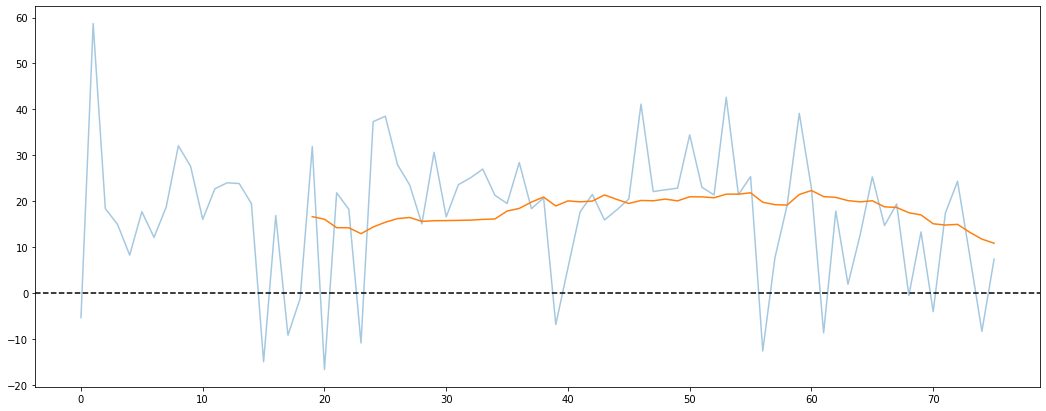

In [48]:
plt.figure(figsize=(18,7))
plt.plot(reward_list, alpha=0.4)
reward_list = pd.Series(reward_list)
plt.plot(reward_list.rolling(20).mean())
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

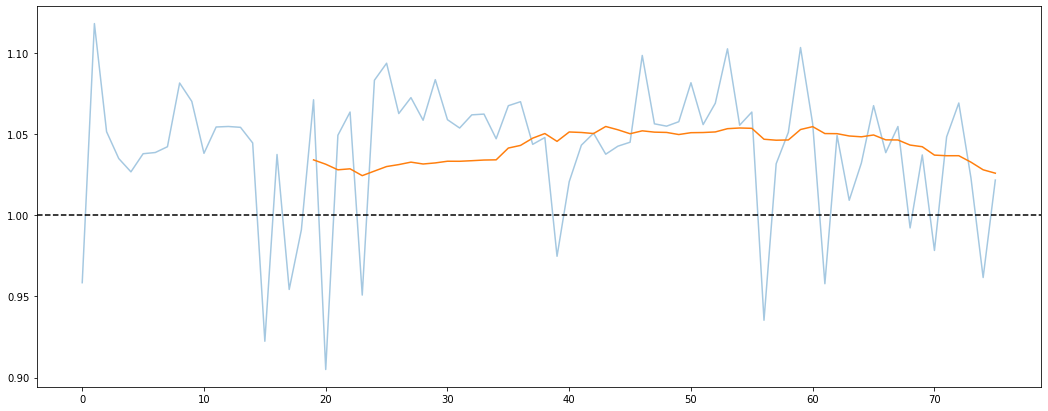

In [49]:
plt.figure(figsize=(18,7))
plt.plot(arr_list, alpha=0.4)
arr_list = pd.Series(arr_list)
plt.plot(arr_list.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

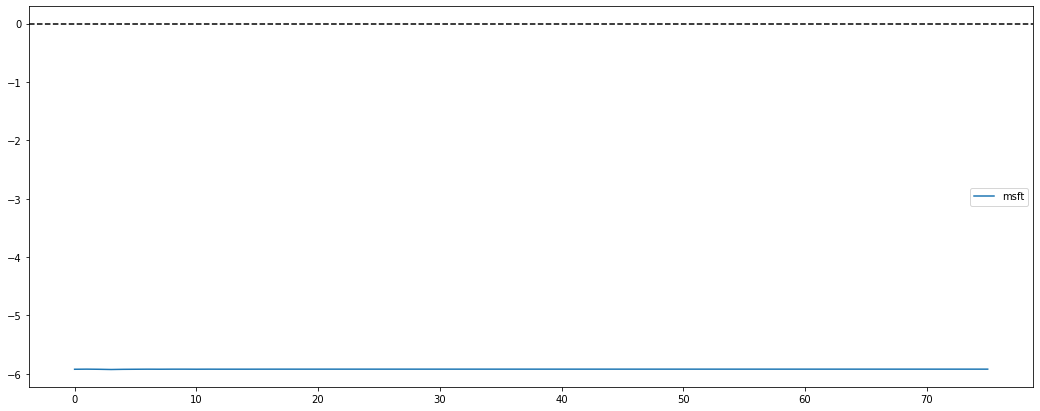

In [50]:
plt.figure(figsize=(18,7))
plt.plot(vreward_list, label='msft')
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.legend()
plt.show()

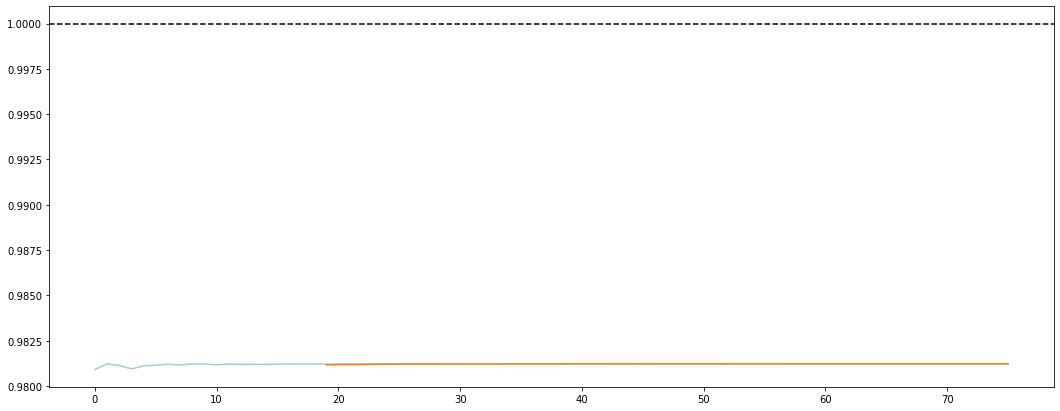

In [51]:
plt.figure(figsize=(18,7))
plt.plot(varr_list, alpha=0.4)
varr_list = pd.Series(varr_list)
plt.plot(varr_list.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

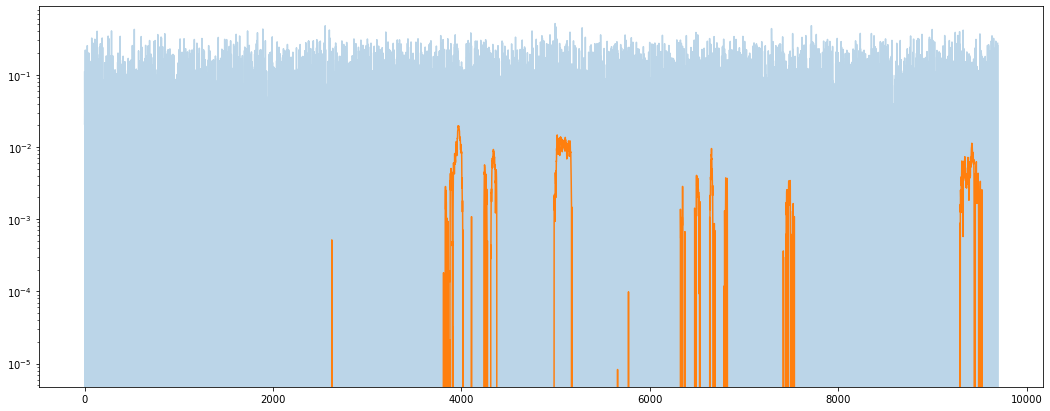

In [52]:
plt.figure(figsize=(18,7))
plt.plot(all_aloss, alpha=0.3)
aloss_series = pd.Series(all_aloss)
plt.plot(aloss_series.rolling(200).mean())
plt.yscale('log')
#plt.ylim(1,1e5)
plt.show()

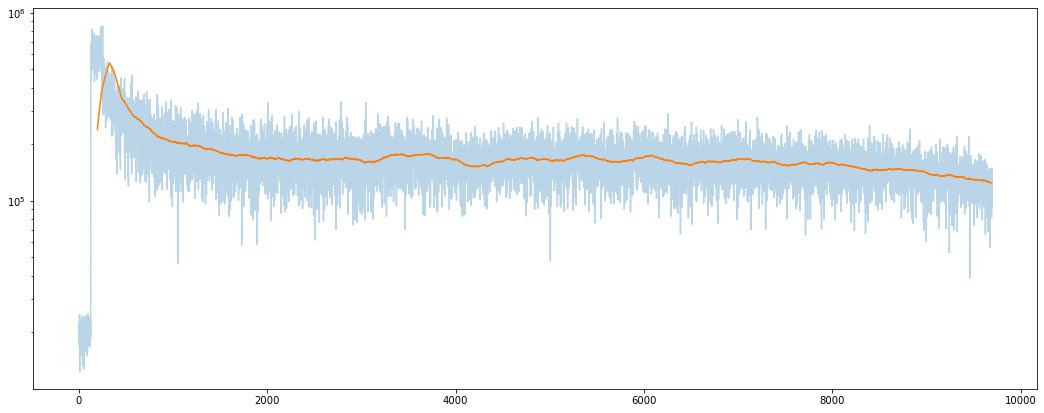

In [53]:
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=0.3)
closs_series = pd.Series(all_closs)
plt.plot(closs_series.rolling(200).mean())
plt.yscale('log')
#plt.ylim(1,1e5)
plt.show()

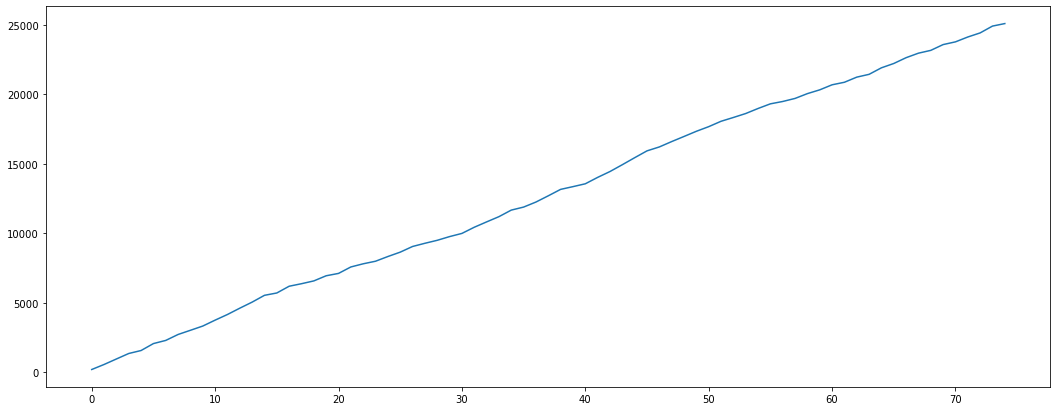

In [54]:
plt.figure(figsize=(18,7))
plt.plot(np.cumsum(durations))
plt.show()

In [55]:
#valid_model.set_weights(best_weights)
valid_model.set_weights(actor.get_weights())

In [48]:
'''msft = msft_train.append(msft_valid, ignore_index=True)
dis = dis_train.append(dis_valid, ignore_index=True)
jnj = jnj_train.append(jnj_valid, ignore_index=True)'''

C:\Users\isaac\AppData\Local\Temp\ipykernel_24452\3280110641.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msft = msft_train.append(msft_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_24452\3280110641.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis = dis_train.append(dis_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_24452\3280110641.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jnj = jnj_train.append(jnj_valid, ignore_index=True)


In [80]:
load_model('cga_weights.h5', 'cga/msft/noisydense/noisydata/86episodes', valid_model)

In [81]:
msft_test_env = CGA_Env(msft_test, random_ofs_on_reset=False, noise_on=False)
dis_test_env = CGA_Env(dis_test, random_ofs_on_reset=False, noise_on=False)
jnj_test_env = CGA_Env(jnj, random_ofs_on_reset=False, noise_on=False)

In [82]:
mean, arr, full_reward_list, actions, returns = valid_run(msft_test_env)

In [83]:
#msft
arr

1.1247808901272787

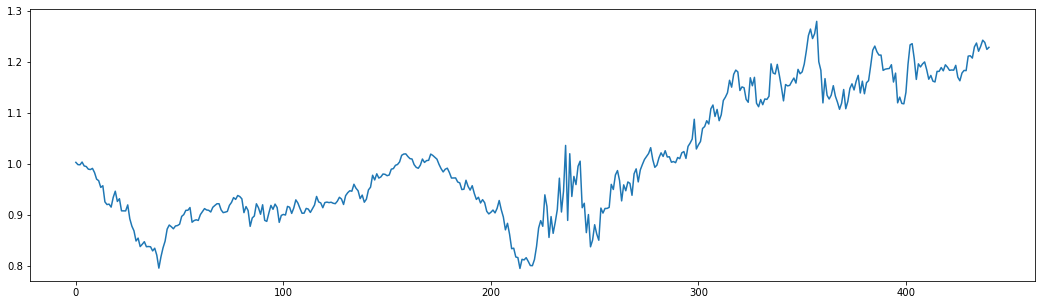

In [84]:
#msft
plt.figure(figsize=(18,5))
plt.plot(np.cumprod(returns))
plt.show()

In [69]:
#dis
arr

1.5368906374583435

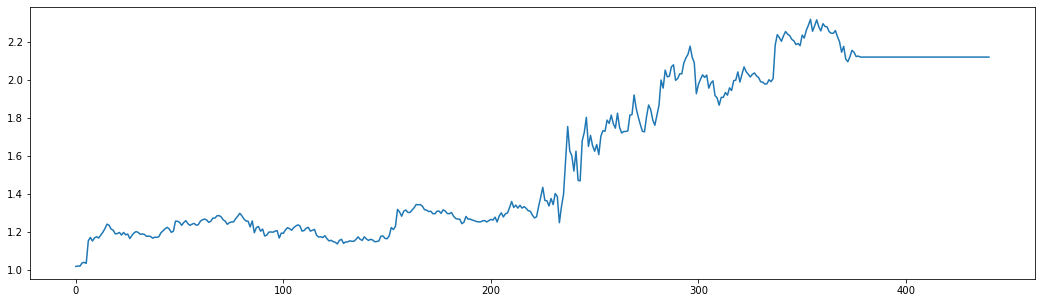

In [70]:
#dis
plt.figure(figsize=(18,5))
plt.plot(np.cumprod(returns))
plt.show()

In [115]:
#jnj
arr

1.1079965667393175

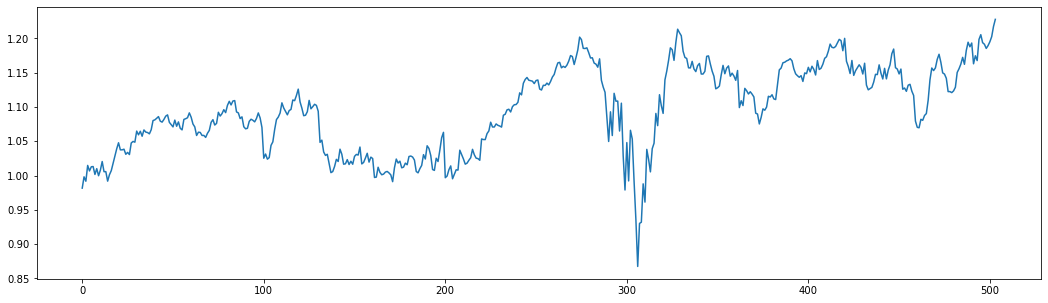

In [116]:
#jnj
plt.figure(figsize=(18,5))
plt.plot(np.cumprod(returns))
plt.show()

In [74]:
#msft
mean

-0.25725090352624425

In [59]:
#dis
mean

43.72857708700688

In [117]:
#jnj
mean

8.986163025169997

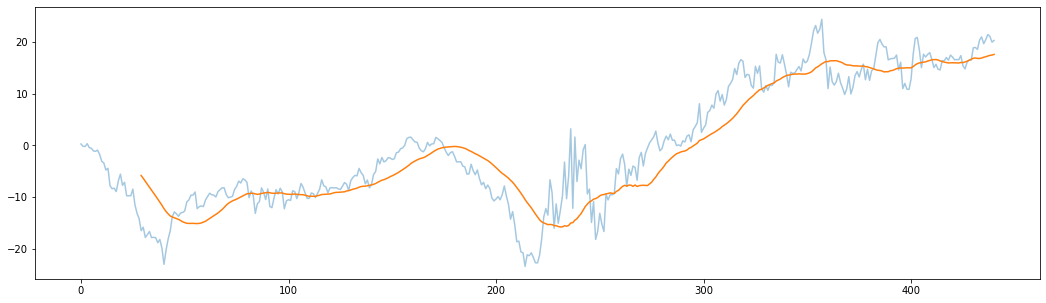

In [75]:
#msft
plt.figure(figsize=(18,5))
plt.plot(full_reward_list, alpha=0.4)
full_reward_series = pd.Series(full_reward_list)
plt.plot(full_reward_series.rolling(30).mean())
#plt.axhline(y = 100, color = 'black', linestyle = '--')
#plt.ylim(90,110)
plt.show()

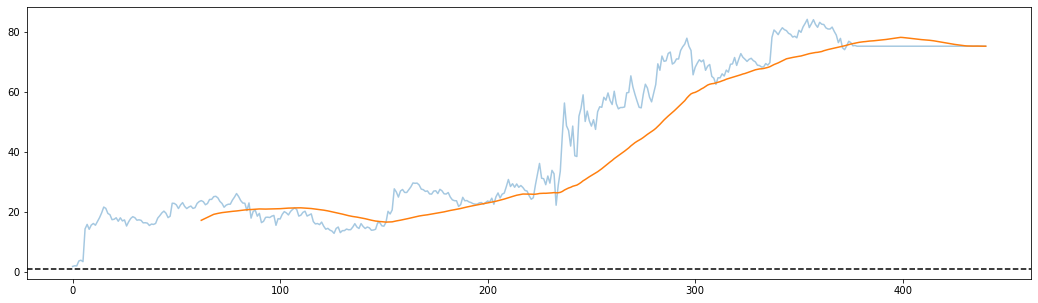

In [60]:
#dis
plt.figure(figsize=(18,5))
plt.plot(full_reward_list, alpha=0.4)
full_reward_series = pd.Series(full_reward_list)
plt.plot(full_reward_series.rolling(63).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

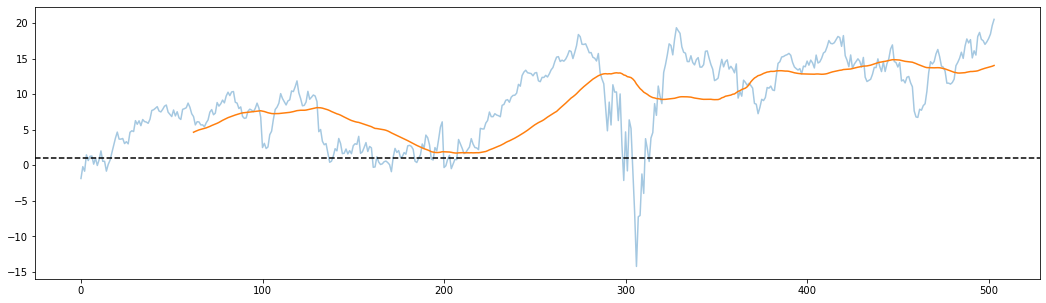

In [118]:
#jnj
plt.figure(figsize=(18,5))
plt.plot(full_reward_list, alpha=0.4)
full_reward_series = pd.Series(full_reward_list)
plt.plot(full_reward_series.rolling(63).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

In [76]:
actions[-10:]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [77]:
actions.append(1)

In [78]:
len(actions)

441

In [62]:
msft.shape

(5221, 24)

In [63]:
def point_type_listmaker(prices):
    length = len(prices.close)
    train = prices.loc[63:]
    train.reset_index(inplace=True, drop=True)
    #print(type(prices))
    #print(type(train))
    #print(type(actions))
    #train['action'] = actions
    buy_rows = train.loc[train['signals'] == 0]
    short_rows = train.loc[train['signals'] == 1]

    return buy_rows, short_rows

In [64]:
def eam_plotter(prices, stock, actions):
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(18,14))
    #plt.figure(figsize=(18,7))
    plt.ylabel('Confidence Value')
    ax1.plot(prices.date.loc[63:], prices.close.loc[63:], color='black')
    longs, shorts = point_type_listmaker(prices)
    
    ax1.scatter(longs.date, longs.close, color='green', marker='o', label='Signal-Long', alpha=0.3)
    ax1.scatter(shorts.date, shorts.close, color='red', marker='o', label='Signal-Short', alpha=0.3)
    
    ax2.plot(prices.date.loc[63:], actions, alpha=0.5)
    ax2.axhline(y = 0, color = 'black', linestyle = '--')
    #plt.yticks(np.arange(-1,1,step=0.5))
    
    
    plt.axis('tight')
    plt.xlabel('Date')
    plt.title('Side and Confidence Signals')
    ax1.legend()

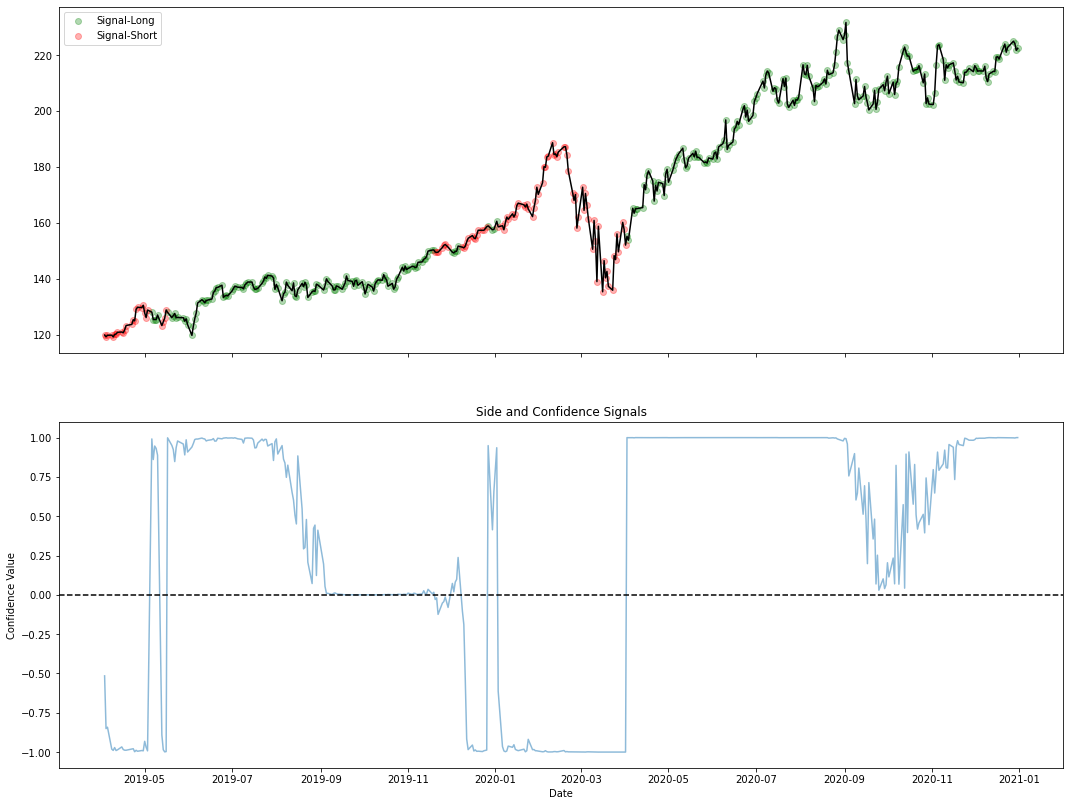

In [65]:
#msft
eam_plotter(msft_test, 'MSFT', actions)
#plt.savefig('msft_signals_and_conf.png')

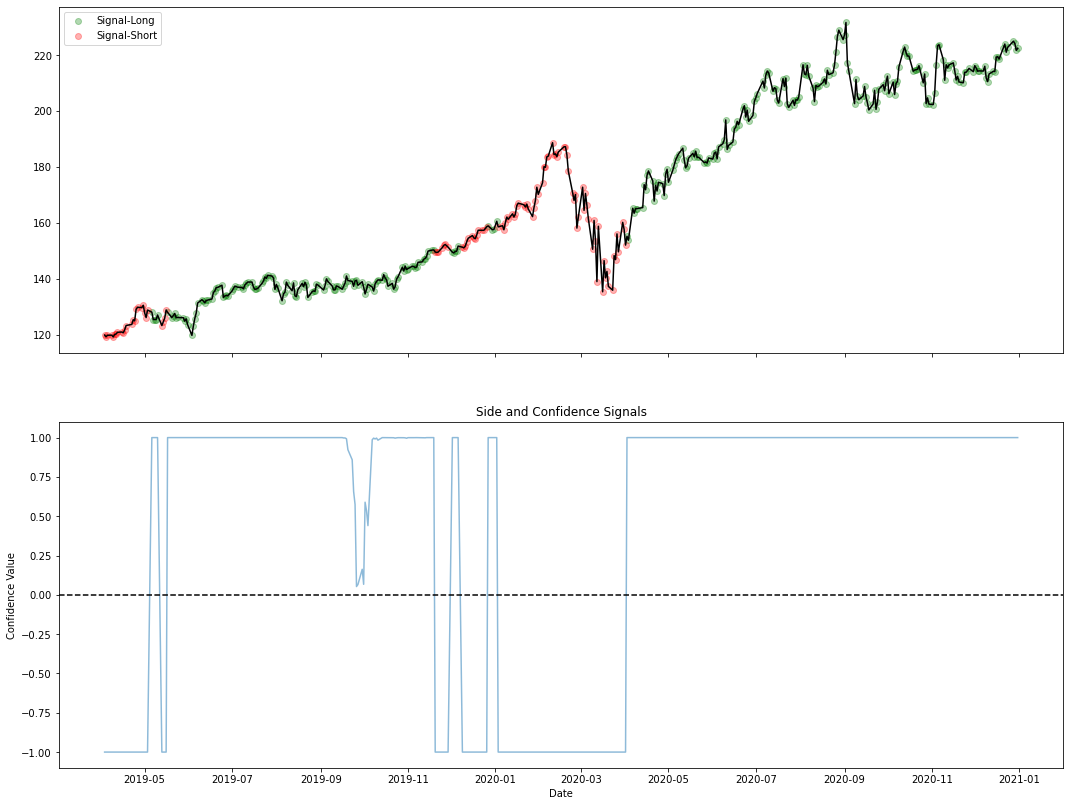

In [78]:
#msft
eam_plotter(msft_test, 'MSFT', actions)
#plt.savefig('msft_signals_and_conf.png')

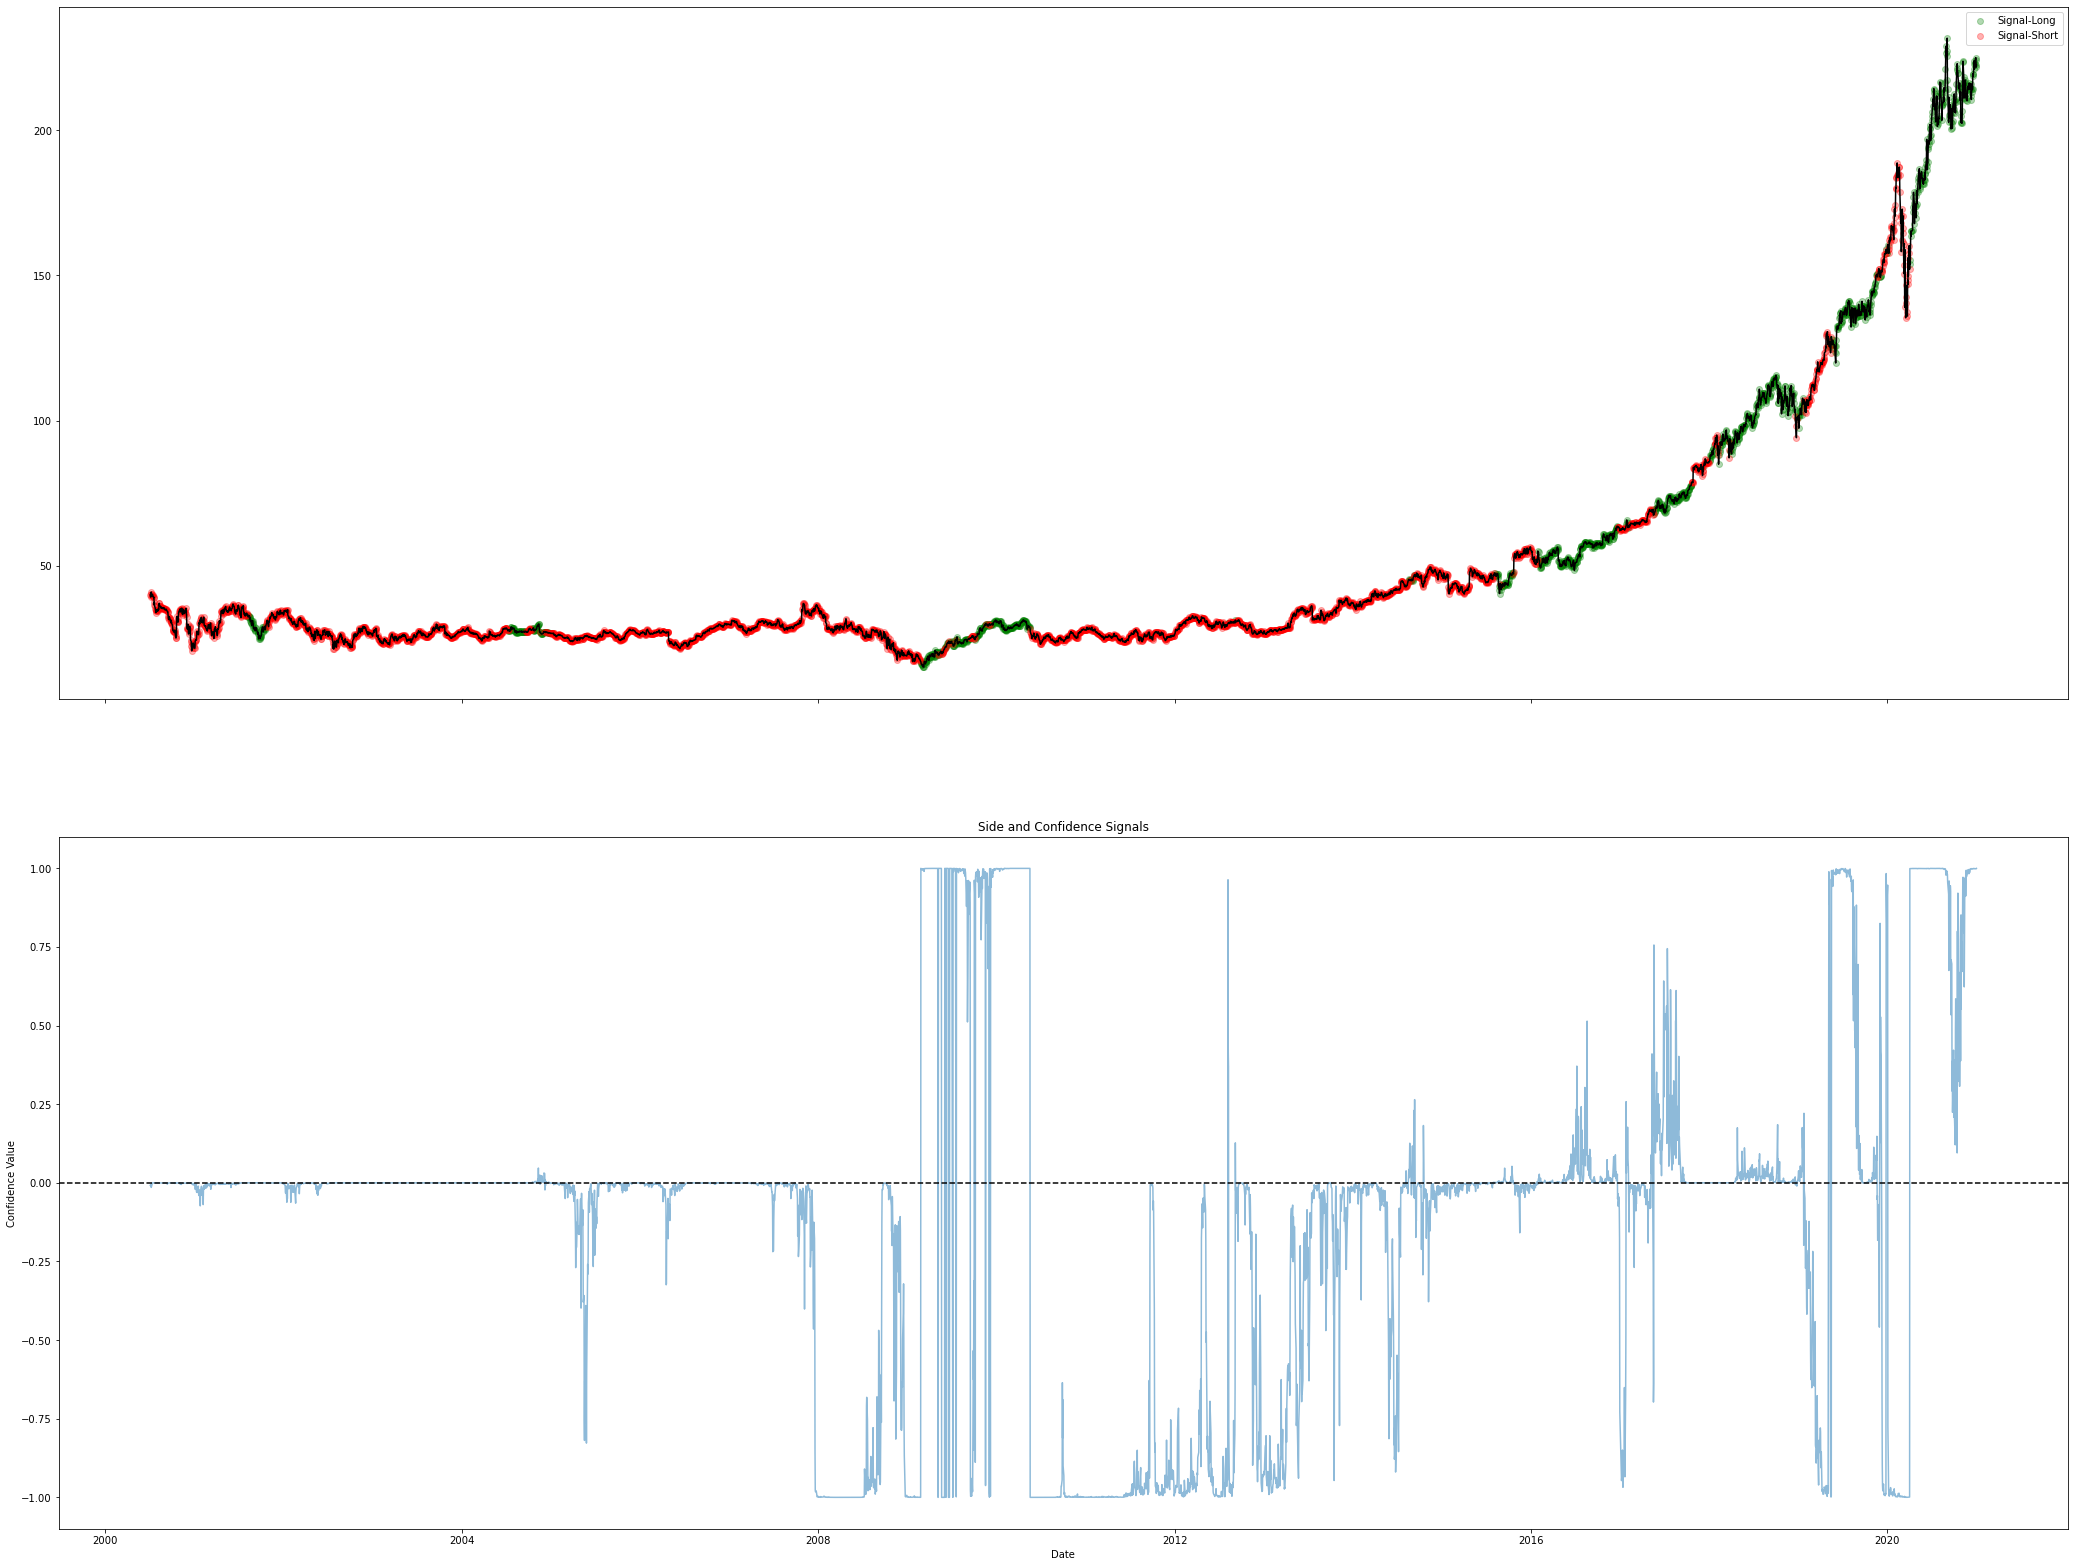

In [79]:
#msft
eam_plotter(msft, 'MSFT', actions)
#plt.savefig('msft_signals_and_conf.png')

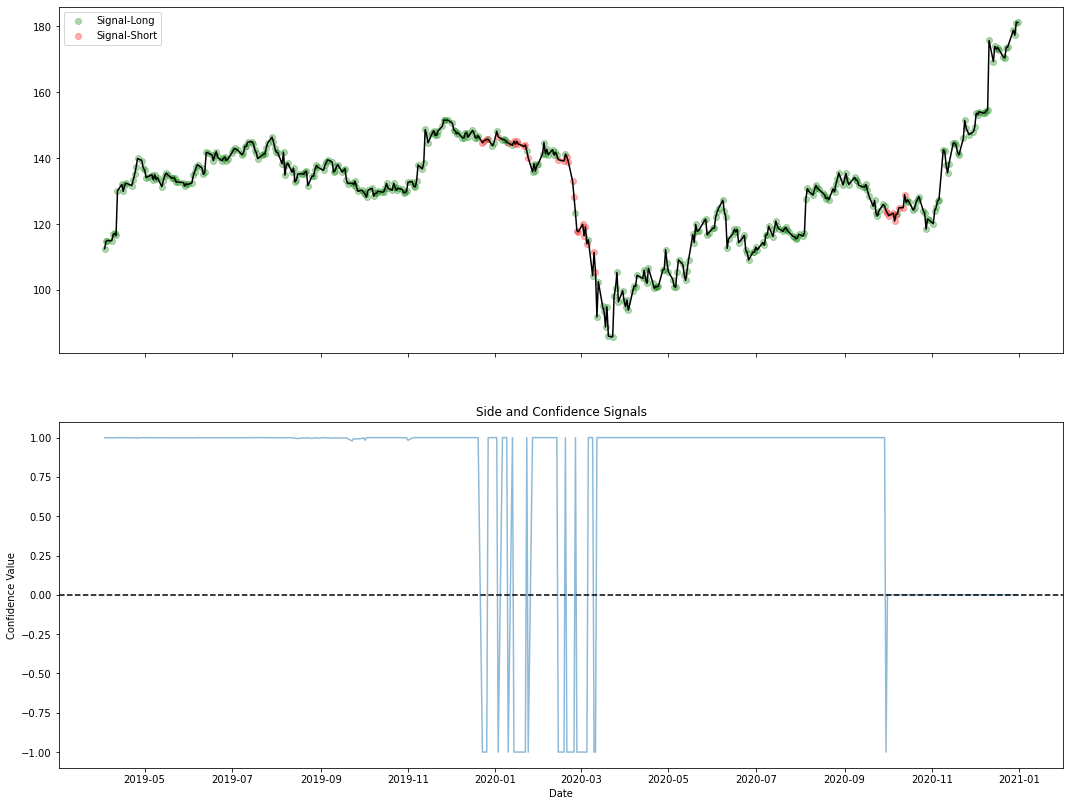

In [65]:
#dis best weights on dis
eam_plotter(dis_test, 'DIS', actions)
plt.savefig('dis_signals_and_conf.png')

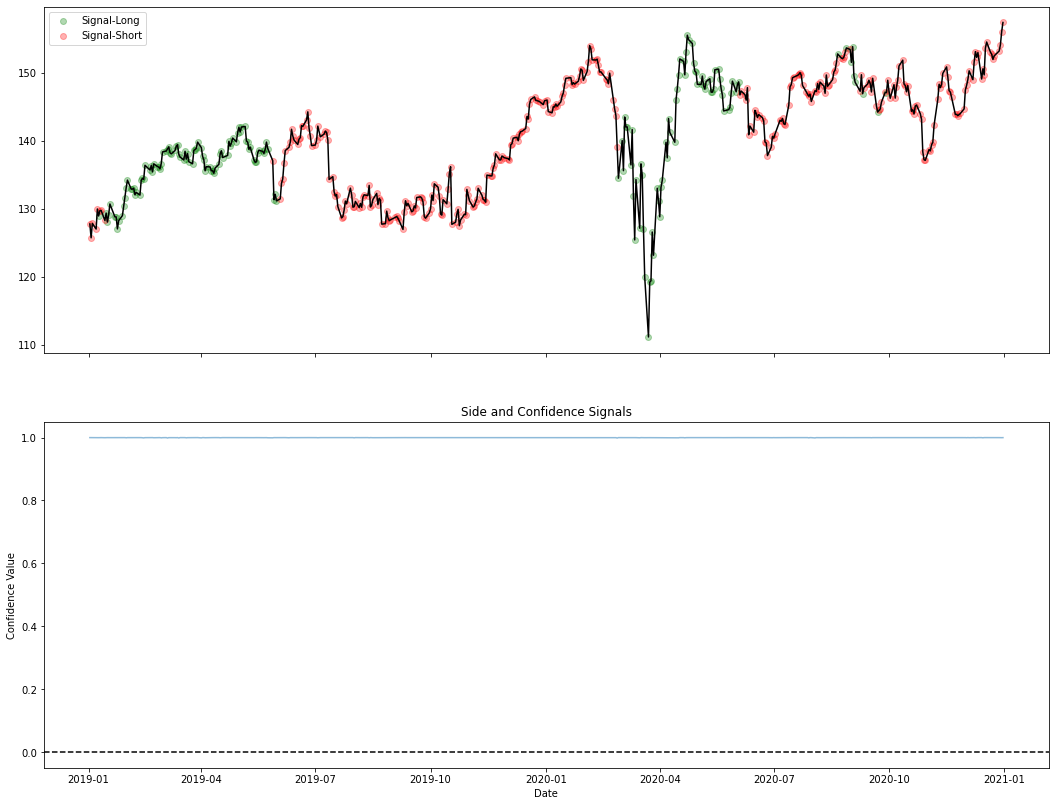

In [99]:
#jnj best weights on jnj
eam_plotter(jnj_test, 'JNJ', actions)
plt.savefig('jnj_signals_and_conf.png')

In [81]:
type(model.get_weights())

list

In [75]:
len(replay_buffer)

49665

In [76]:
series = pd.Series(replay_buffer)

In [77]:
with pd.HDFStore('sga_buffer.h5') as store:
    store.put('sga/dis/noisydata/log/250episodes', series)

C:\Users\isaac\AppData\Local\Temp\ipykernel_14016\3253804927.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put('sga/dis/noisydata/log/250episodes', series)


In [66]:
save_model('cga_weights.h5', 'cga/msft/noisydense/noisydata/86episodes', valid_model)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0to1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '74episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_30300\3535736476.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [79]:
save_model('cga_weights.h5', 'cga/msft/noisydense/noisydata/0to1/151episodes', valid_model)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '151episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_30300\3535736476.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [135]:
save_model('cga_weights.h5', 'cga/dis/noisydense/noisydata/diffsharperatio_n0.1/90episodes', valid_model)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '90episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_24452\3535736476.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [122]:
action_series = pd.Series(actions)
with pd.HDFStore('cga_signals.h5') as store:
    store.put('cga/test/arr/jnj', action_series)